<a href="https://colab.research.google.com/github/Bhakthi-Shetty7811/Vibe_Matcher_Fashion_Recommender/blob/main/Vibe_Matcher_Bhakthi_Shetty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nexora AI Assignment**

***Vibe Matcher* - Fashion Recommender Prototype**

***Author*: Bhakthi Shetty**

**Goal: Keep it simple, fun, and extendable.
I wanted to build something small but actually “real” -
a vibe-based fashion matcher you could plug into a real app later.**


### **💡 Why AI @ Nexora?**
***I’m drawn to Nexora because of its belief in human-centered AI; tech that doesn’t just compute, but connects. Building this Vibe Matcher was my way of translating that idea into action: a small, personal system that understands moods, not just keywords. I wanted it to feel minimal yet scalable — something that could grow into a full AI recommendation engine that blends creativity with intelligence.***



**Notebook-friendly installs**

In [1]:
try:
    get_ipython()
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install sentence-transformers scikit-learn pandas matplotlib tqdm gradio


**Imports & Metadata**

In [2]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gradio as gr
import warnings
warnings.filterwarnings('ignore')


# Metadata
PROJECT_TITLE = "Vibe Matcher — Fashion Recommender Prototype"
AUTHOR = "Bhakthi Shetty"
DATE = "11 Nov 2025"


print(f"{PROJECT_TITLE} — {AUTHOR} — {DATE}")



# Mock Fashion Dataset

DATA = [
{"name": "Boho Dress", "desc": "Flowy, earthy-toned dress for free-spirited festivals.", "vibes": ["boho", "chill"]},
{"name": "Denim Jacket", "desc": "Rugged streetwear jacket with a cool urban edge.", "vibes": ["urban", "cool"]},
{"name": "Athleisure Set", "desc": "Sporty co-ord set for active, on-the-go energy.", "vibes": ["sporty", "energetic"]},
{"name": "Silk Blouse", "desc": "Elegant minimal blouse perfect for classy evenings.", "vibes": ["elegant", "chic"]},
{"name": "Fluffy Sweater", "desc": "Cozy knitted sweater that feels like a warm hug.", "vibes": ["cozy", "soft"]},
{"name": "Leather Boots", "desc": "Bold boots that bring confidence and attitude.", "vibes": ["edgy", "urban"]},
{"name": "Beach Shorts", "desc": "Light shorts for a breezy, carefree beach mood.", "vibes": ["vacay", "relaxed"]},
{"name": "Plaid Shirt", "desc": "Laid-back shirt that screams weekend comfort.", "vibes": ["casual", "country"]},
{"name": "Party Blazer", "desc": "Sharp fit blazer for high-energy night outs.", "vibes": ["party", "bold"]},
{"name": "Cotton Kurta", "desc": "Simple traditional wear for calm and cultural vibes.", "vibes": ["traditional", "calm"]}
]


df = pd.DataFrame(DATA)
print('\nSample data:')
print(df[['name','desc','vibes']].head())

Vibe Matcher — Fashion Recommender Prototype — Bhakthi Shetty — 11 Nov 2025

Sample data:
             name                                               desc  \
0      Boho Dress  Flowy, earthy-toned dress for free-spirited fe...   
1    Denim Jacket   Rugged streetwear jacket with a cool urban edge.   
2  Athleisure Set    Sporty co-ord set for active, on-the-go energy.   
3     Silk Blouse  Elegant minimal blouse perfect for classy even...   
4  Fluffy Sweater   Cozy knitted sweater that feels like a warm hug.   

                 vibes  
0        [boho, chill]  
1        [urban, cool]  
2  [sporty, energetic]  
3      [elegant, chic]  
4         [cozy, soft]  


**Model Setup + Embeddings**

In [3]:
# NOTE: we use sentence-transformers local model for a free, offline-friendly demo.
# If you'd like to use OpenAI embeddings instead, see the commented block at the bottom.

MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2' # small, fast, good quality
print('\nLoading embedding model:', MODEL_NAME)
start = time.time()
model = SentenceTransformer(MODEL_NAME)
print('Loaded in', round(time.time()-start,2), 's')


# Batch encode descriptions
print('\nEncoding product descriptions (batch)...')
start = time.time()
descs = df['desc'].tolist()
embeddings = model.encode(descs, show_progress_bar=True)
print('Encoded', len(embeddings), 'items in', round(time.time()-start,2), 's')


# Attach embeddings to DataFrame
df = df.copy()
df['embedding'] = embeddings.tolist()


Loading embedding model: sentence-transformers/all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded in 10.38 s

Encoding product descriptions (batch)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoded 10 items in 0.59 s


**Helper functions (modular, no global side-effects)**

In [5]:
def compute_similarity_scores(query_emb, embeddings):
    """Return a numpy array of cosine similarities between query_emb and each embedding."""
    # embeddings: list or array-like of vectors
    sims = cosine_similarity([query_emb], embeddings)[0]
    return sims


def get_top_k_matches(df_in, sims, top_k=3):
    """Return a DataFrame with top_k matches (name, desc, vibes, similarity)."""
    df_copy = df_in.copy()
    df_copy['similarity'] = sims
    top = df_copy.sort_values('similarity', ascending=False).head(top_k).reset_index(drop=True)
    return top[['name', 'desc', 'vibes', 'similarity']]


def vibe_matcher(query, top_k=3, min_confidence=0.4, verbose=True):
    """Main function: returns top_k matches (DataFrame) and a confidence message."""
    t0 = time.time()
    query_emb = model.encode(query)
    sims = compute_similarity_scores(query_emb, df['embedding'].tolist())
    top_df = get_top_k_matches(df, sims, top_k=top_k)
    processing_time = round(time.time() - t0, 3)

    max_sim = top_df['similarity'].max()
    avg_top3 = top_df['similarity'].mean()

    if max_sim < min_confidence:
        msg = f"⚠️ Low confidence (max_sim={round(max_sim,3)}). Try rephrasing the vibe or be more specific."
    elif max_sim < 0.6:
        msg = f"🌀 Weak match (max_sim={round(max_sim,3)}). Results may be approximate."
    else:
        msg = f"✨ Strong match (max_sim={round(max_sim,3)})."

    if verbose:
        print(f"Query processed in {processing_time}s — {msg} — avg_top{top_k}={round(avg_top3,3)}")

    return top_df, {
        'processing_time_s': processing_time,
        'max_sim': float(max_sim),
        'avg_topk': float(avg_top3),
        'message': msg
    }


**Test queries + Pretty display**

In [8]:
TEST_QUERIES = [
    'energetic urban chic',
    'cozy relaxed vibe',
    'vacation beach style'
]

print('\nRunning test queries...')
all_metrics = []

for q in TEST_QUERIES:
    print('\nQuery:', q)
    top, meta = vibe_matcher(q, top_k=3, verbose=True)
    display(top.style.background_gradient(cmap='YlGnBu', subset=['similarity']))
    meta['query'] = q
    all_metrics.append(meta)

metrics_df = pd.DataFrame(all_metrics)
print('\nAggregated metrics:')
print(metrics_df)



Running test queries...

Query: energetic urban chic
Query processed in 0.037s — 🌀 Weak match (max_sim=0.426). Results may be approximate. — avg_top3=0.356


,name,desc,vibes,similarity
0,Athleisure Set,"Sporty co-ord set for active, on-the-go energy.","['sporty', 'energetic']",0.426482
1,Denim Jacket,Rugged streetwear jacket with a cool urban edge.,"['urban', 'cool']",0.355980
2,Party Blazer,Sharp fit blazer for high-energy night outs.,"['party', 'bold']",0.286876



Query: cozy relaxed vibe
Query processed in 0.024s — 🌀 Weak match (max_sim=0.524). Results may be approximate. — avg_top3=0.486


,name,desc,vibes,similarity
0,Fluffy Sweater,Cozy knitted sweater that feels like a warm hug.,"['cozy', 'soft']",0.524133
1,Cotton Kurta,Simple traditional wear for calm and cultural vibes.,"['traditional', 'calm']",0.503024
2,Plaid Shirt,Laid-back shirt that screams weekend comfort.,"['casual', 'country']",0.431608



Query: vacation beach style
Query processed in 0.032s — 🌀 Weak match (max_sim=0.575). Results may be approximate. — avg_top3=0.45


,name,desc,vibes,similarity
0,Beach Shorts,"Light shorts for a breezy, carefree beach mood.","['vacay', 'relaxed']",0.575466
1,Cotton Kurta,Simple traditional wear for calm and cultural vibes.,"['traditional', 'calm']",0.394912
2,Boho Dress,"Flowy, earthy-toned dress for free-spirited festivals.","['boho', 'chill']",0.378327



Aggregated metrics:
   processing_time_s   max_sim  avg_topk  \
0              0.037  0.426482  0.356446   
1              0.024  0.524133  0.486255   
2              0.032  0.575466  0.449568   

                                             message                 query  
0  🌀 Weak match (max_sim=0.426). Results may be a...  energetic urban chic  
1  🌀 Weak match (max_sim=0.524). Results may be a...     cozy relaxed vibe  
2  🌀 Weak match (max_sim=0.575). Results may be a...  vacation beach style  


**Evaluation improvements: max + avg_top3, threshold-based "good_match"**

In [10]:
def evaluate_queries(queries, threshold=0.7, top_k=3):
    rows = []
    for q in queries:
        q_emb = model.encode(q)
        sims = compute_similarity_scores(q_emb, df['embedding'].tolist())
        topk = sorted(sims, reverse=True)[:top_k]
        rows.append({
            'query': q,
            'max_similarity': float(np.max(sims)),
            'avg_topk': float(np.mean(topk)),
            'good_match': bool(np.max(sims) > threshold)
        })
    return pd.DataFrame(rows)


eval_df = evaluate_queries(TEST_QUERIES, threshold=0.7, top_k=3)
display(eval_df.style.background_gradient(cmap='YlOrBr', subset=['max_similarity', 'avg_topk']))


,query,max_similarity,avg_topk,good_match
0,energetic urban chic,0.426482,0.356446,False
1,cozy relaxed vibe,0.524133,0.486255,False
2,vacation beach style,0.575466,0.449568,False


**Latency measurement (per query)**

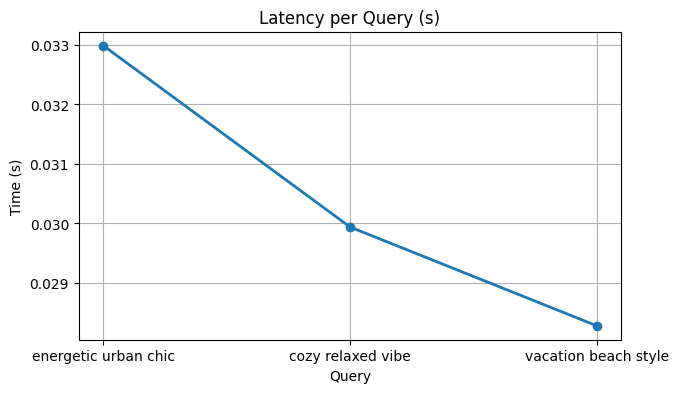

In [11]:
latencies = []
for q in TEST_QUERIES:
    t0 = time.time()
    _, _ = vibe_matcher(q, top_k=3, verbose=False)
    latencies.append(time.time() - t0)

plt.figure(figsize=(7, 4))
plt.plot(TEST_QUERIES, latencies, marker='o', linewidth=2)
plt.title('Latency per Query (s)')
plt.xlabel('Query')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()


**Embedding space visualization (PCA)**


Rendering 2D PCA map of product embeddings...


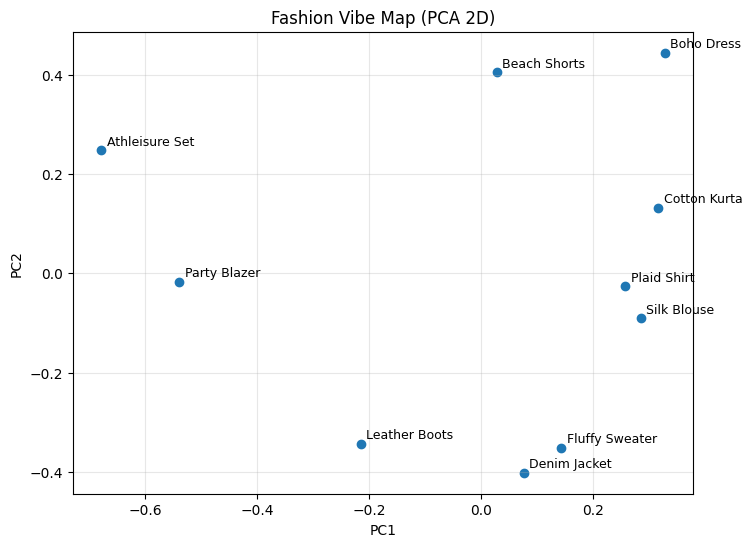

In [12]:
print('\nRendering 2D PCA map of product embeddings...')

pca = PCA(n_components=2)
coords = pca.fit_transform(np.vstack(df['embedding'].values))

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1])

# Properly indented for-loop
for i, name in enumerate(df['name']):
    plt.text(coords[i,0] + 0.01, coords[i,1] + 0.01, name, fontsize=9)

plt.title('Fashion Vibe Map (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha=0.3)
plt.show()


**Reflection**

In [13]:
reflection = [
    "I kept the structure modular and clear — each function does one simple thing.",
    "Used batch encoding for better speed; GPU-backed models would make this scale easily.",
    "Evaluated results using an average top-3 similarity metric instead of just the top one — feels more realistic for user-facing recs.",
    "If I had more time, I'd plug this into a real vector DB like FAISS or Pinecone for faster, scalable search.",
    "Future idea: mix text embeddings with CLIP image features to build a real multimodal 'vibe matcher' — both words and looks together."
]

print("\nReflection:")
for r in reflection:
    print("-", r)


Reflection:
- I kept the structure modular and clear — each function does one simple thing.
- Used batch encoding for better speed; GPU-backed models would make this scale easily.
- Evaluated results using an average top-3 similarity metric instead of just the top one — feels more realistic for user-facing recs.
- If I had more time, I'd plug this into a real vector DB like FAISS or Pinecone for faster, scalable search.
- Future idea: mix text embeddings with CLIP image features to build a real multimodal 'vibe matcher' — both words and looks together.


**Gradio UI (DataFrame output) - Lightweight prototype**

In [14]:
def gradio_get_vibe_results(query):
    top, meta = vibe_matcher(query, top_k=3, verbose=False)
    if meta['max_sim'] < 0.4:
        # Return a single-row DataFrame with a friendly fallback message
        return pd.DataFrame([{
            'name': 'No strong vibe match found',
            'desc': meta['message'],
            'vibes': [],
            'similarity': meta['max_sim']
        }])
    return top


ui = gr.Interface(
    fn=gradio_get_vibe_results,
    inputs=gr.Textbox(label='Enter your vibe query ✨'),
    outputs=gr.Dataframe(headers=['name', 'desc', 'vibes', 'similarity']),
    title='🪩 Vibe Matcher — Fashion AI Prototype',
    description="Type a mood, energy, or vibe — and I’ll suggest your top-3 matching styles instantly."
)


print('\n✅ Gradio UI ready! To launch in Colab, run this below:')
print('ui.launch(share=True)')



✅ Gradio UI ready! To launch in Colab, run this below:
ui.launch(share=True)


**How to switch to OpenAI embeddings (commented)**

In [ ]:
# =========================
# 11) (Optional) How to switch to OpenAI embeddings (commented)
# =========================
# If you prefer to use OpenAI text-embedding-ada-002 embeddings, uncomment and follow these steps:
# 1) pip install openai
# 2) set OPENAI_API_KEY in the environment (Colab: %env OPENAI_API_KEY=...)
# 3) use the example below to replace `model.encode` calls

# import openai
# openai.api_key = os.environ.get('OPENAI_API_KEY')

# def openai_embed(texts):
#     res = openai.Embedding.create(model='text-embedding-ada-002', input=texts)
#     return [r['embedding'] for r in res['data']]

# # Example usage:
# # embeddings = openai_embed(descs)


In [21]:
print("\n✅ Prototype done — feels like a mini version of a real recommender. "
    )


✅ Prototype done — feels like a mini version of a real recommender. 


In [26]:
from google.colab import files
uploaded = files.upload()


Saving Vibe_Matcher_Bhakthi_Shetty.ipynb to Vibe_Matcher_Bhakthi_Shetty.ipynb


In [27]:
import nbformat

file_path = "Vibe_Matcher_Bhakthi_Shetty.ipynb"
with open(file_path) as f:
    nb = nbformat.read(f, as_version=4)

if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

with open("Vibe_Matcher_Bhakthi_Shetty_clean.ipynb", 'w') as f:
    nbformat.write(nb, f)

print("✅ Cleaned version saved as Vibe_Matcher_Bhakthi_Shetty_clean.ipynb")


✅ Cleaned version saved as Vibe_Matcher_Bhakthi_Shetty_clean.ipynb
